# 🚢 Titanic Machine Learning Classifier: Predicting Survival

## 🎯 Project Overview
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, resulting in the deaths of 1502 out of 2224 passengers and crew.

This project is a classic binary classification challenge: **using machine learning to predict which passengers survived the tragedy based on individual characteristics**. Success in this project demonstrates core data science skills: data analysis, feature engineering, model selection, and hyperparameter tuning.

## 📊 Dataset Attributes Overview

The data has been split into two groups:
- **`train_df`** (891 entries): Used to build our machine learning models. Contains the target variable `Survived`.
- **`test_df`** (418 entries): Used to test the model's predictive power. Does not contain the target variable.

### **Input Variables (Features)**

**A.i. Passenger Characteristics**
*   `PassengerId`: A unique identifier for each passenger.
*   `Pclass`: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). A strong proxy for socio-economic status.
*   `Name`: Passenger's name. Contains titles (Mr, Mrs, Miss, etc.) which we will engineer into a new feature.
*   `Sex`: Passenger's sex (male/female). A crucial predictor due to the "women and children first" protocol.
*   `Age`: Passenger's age in years. Fractional for children under 1.
*   `SibSp`: Number of siblings / spouses aboard the Titanic.
*   `Parch`: Number of parents / children aboard the Titanic.

**A.ii. Ticket & Fare Information**
*   `Ticket`: Ticket number. Contains prefixes and numbers which can be engineered into features like group size and ticket class.
*   `Fare`: Passenger fare paid. Correlates strongly with `Pclass` but provides continuous value.

**A.iii. Embarkation & Cabin**
*   `Cabin`: Cabin number. Heavily missing, but the first letter indicates the deck, which is linked to survival rates.
*   `Embarked`: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

### **Output Variable (Target)**
*   `Survived`: Survival status (0 = No, 1 = Yes). This is the binary label we are trying to predict.

## 🧠 Our Approach & Strategy

This notebook will follow a structured machine learning workflow:

1.  **Exploratory Data Analysis (EDA)**: Understanding the underlying relationships between features and survival.
2.  **Feature Engineering**: The core of this project. We will create powerful new predictors from raw data:
    *   Extracting **Titles** from passenger names.
    *   Creating **Family Size** and **Family Group** from `SibSp` and `Parch`.
    *   Binning **Age** and **Fare** into ordinal categories based on survival rates.
    *   Analyzing **Name Length** as a potential proxy for social status.
    *   Extracting information from **Ticket** numbers (group size, prefix).
    *   Leveraging **Cabin** data by creating a simple binary flag for its presence.
3.  **Data Preprocessing**: Building a robust pipeline to handle missing values and encode categorical variables consistently.
4.  **Model Benchmarking & Tuning**: Training multiple classifiers (Random Forest, SVM, KNN, etc.) and optimizing their hyperparameters using `GridSearchCV`.
5.  **Evaluation & Submission**: Selecting the best model and generating predictions for the competition.

Let's begin by loading the data and exploring the hidden patterns that determined fate on that fateful night.

In [2]:
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier


from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


In [10]:
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


## Initial Survival Rate Analysis
The first `groupby` operations reveal clear, strong relationships that confirm historical accounts:
*   **Class Matters**: 1st class passengers had a much higher survival rate (63%) than 3rd class (24%).
*   **"Women & Children First"**: The policy is starkly evident. Females had a 74% survival rate vs. 19% for males.
*   **Family Ties**: Passengers with 1-3 family members (SibSp + Parch) had higher survival rates than those traveling alone or with very large families.

These insights validate our initial approach and highlight the most important raw features. Now we will engineer new features based on these patterns.

In [14]:
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1


In [15]:
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [16]:
fam_map = {1:'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 
           5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
train_df['Family_Size_Grouped'] = train_df['Family_Size'].map(fam_map)
test_df['Family_Size_Grouped'] = test_df['Family_Size'].map(fam_map)

In [17]:
train_df.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()

,Family_Size_Grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


### Creating Family Size Groups
We've combined `SibSp` and `Parch` into a `Family_Size` feature and then bucketed them into meaningful groups: 'Alone', 'Small', 'Medium', 'Large'. This simplifies the pattern and makes it easier for the model to learn. The survival rate for 'Small' families (58%) is significantly higher than for those traveling 'Alone' (30%).

In [18]:
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


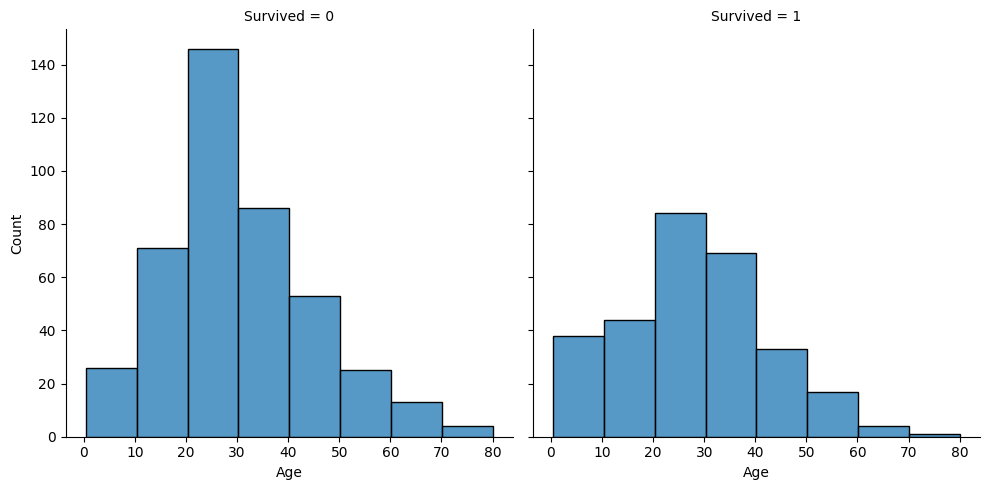

In [19]:
sns.displot(train_df, x='Age', col='Survived', binwidth = 10)

In [20]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 8)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 8)

In [21]:
train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_20164\1587675067.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()


,Age_Cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [22]:
train_df.loc[train_df['Age'] <= 19, 'Age'] = 0
train_df.loc[(train_df['Age'] > 19) & (train_df['Age'] <= 25), 'Age'] = 1
train_df.loc[(train_df['Age'] > 25) & (train_df['Age'] <= 31.8), 'Age'] = 2
train_df.loc[(train_df['Age'] > 31.8) & (train_df['Age'] <= 41), 'Age'] = 3
train_df.loc[(train_df['Age'] > 41) & (train_df['Age'] <= 80), 'Age'] = 4
train_df.loc[train_df['Age'] > 80, 'Age'] 

test_df.loc[test_df['Age'] <= 19, 'Age'] = 0
test_df.loc[(test_df['Age'] > 19) & (test_df['Age'] <= 25), 'Age'] = 1
test_df.loc[(test_df['Age'] > 25) & (test_df['Age'] <= 31.8), 'Age'] = 2
test_df.loc[(test_df['Age'] > 31.8) & (test_df['Age'] <= 41), 'Age'] = 3
test_df.loc[(test_df['Age'] > 41) & (test_df['Age'] <= 80), 'Age'] = 4
test_df.loc[test_df['Age'] > 80, 'Age'] 

Series([], Name: Age, dtype: float64)

### Binning Continuous Variables: Age
We are converting `Age` from a continuous number into an ordinal category (0-4) based on quantile cuts and survival rates. This often improves model performance by highlighting non-linear relationships and reducing the influence of outliers. For example, children (Age bin 0: <=19) had a higher survival rate.

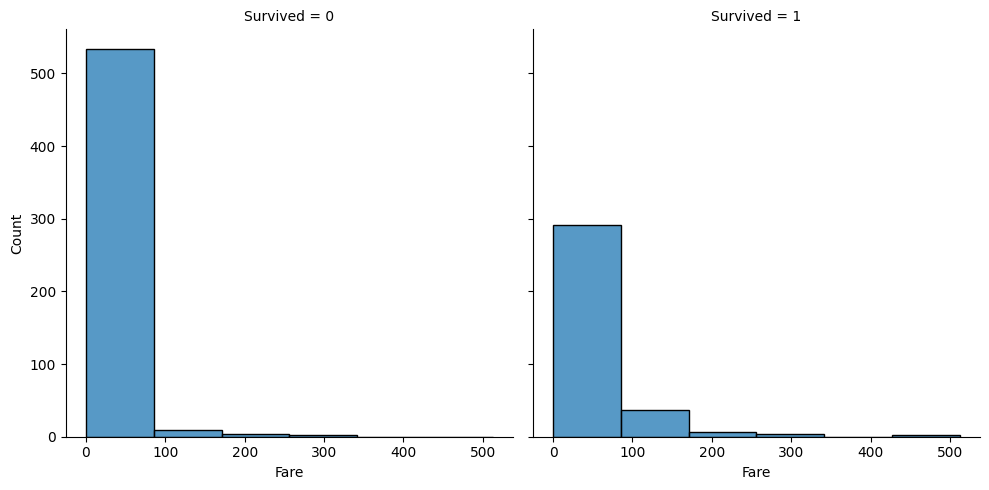

In [23]:
sns.displot(train_df, x='Fare', col='Survived', binwidth=80, height=5)

In [24]:
train_df['Fare_Cut'] = pd.qcut(train_df['Fare'], 6)
test_df['Fare_Cut'] = pd.qcut(test_df['Fare'], 6)

In [25]:
train_df.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_20164\1994933730.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()


,Fare_Cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [26]:
train_df.loc[train_df['Fare'] <= 7.854, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.854) & (train_df['Fare'] <= 10.5), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 10.5) & (train_df['Fare'] <= 21.679), 'Fare'] = 2
train_df.loc[(train_df['Fare'] > 21.679) & (train_df['Fare'] <= 39.688), 'Fare'] = 3
train_df.loc[(train_df['Fare'] > 39.688) & (train_df['Fare'] <= 512.329), 'Fare'] = 4
train_df.loc[train_df['Fare'] > 512.329, 'Fare'] 

test_df.loc[test_df['Fare'] <= 7.854, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.854) & (test_df['Fare'] <= 10.5), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 10.5) & (test_df['Fare'] <= 21.679), 'Fare'] = 2
test_df.loc[(test_df['Fare'] > 21.679) & (test_df['Fare'] <= 39.688), 'Fare'] = 3
test_df.loc[(test_df['Fare'] > 39.688) & (test_df['Fare'] <= 512.329), 'Fare'] = 4
test_df.loc[test_df['Fare'] > 512.329, 'Fare'] 

343    512.3292
Name: Fare, dtype: float64

### Binning Continuous Variables: Fare
We've applied the same binning strategy to `Fare`, creating ordinal categories (0-4). The relationship is clear: passengers who paid higher fares had significantly better survival chances, with the highest fare category (4) having a 70% survival rate.

In [27]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [28]:
train_df['Title'] = train_df['Name'].str.split(pat=",", expand=True)[1].str.split(pat=".", expand=True)[0].apply(lambda x:x.strip())
test_df['Title'] = test_df['Name'].str.split(pat=",", expand=True)[1].str.split(pat=".", expand=True)[0].apply(lambda x:x.strip())


In [29]:
train_df.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [30]:
train_df['Title'] = train_df['Title'].replace({ 
    'Capt': 'Millitary', 
    'Col': 'Millitary', 
    'Major': 'Millitary',
    "Jonkheer": 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble', 
    'Lady': 'Noble', 
    'Sir': 'Noble', 
    'Mlle': 'Noble', 
    'Ms': 'Noble', 
    'Mme': 'Noble'
})

test_df['Title'] = test_df['Title'].replace({ 
    'Capt': 'Millitary', 
    'Col': 'Millitary', 
    'Major': 'Millitary',
    "Jonkheer": 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble', 
    'Lady': 'Noble', 
    'Sir': 'Noble', 
    'Mlle': 'Noble', 
    'Ms': 'Noble', 
    'Mme': 'Noble'
})

In [31]:
train_df.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Millitary,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


### Extracting Social Title from Name
The `Name` column is a goldmine. We've extracted titles (e.g., Mr, Mrs, Master, Miss) which are strong proxies for age, sex, and social status. We've also grouped rare titles into broader categories like 'Noble' and 'Military'. This is often one of the most predictive features in this dataset, with 'Mrs' and 'Miss' having very high survival rates (~79%) and 'Mr' having a very low rate (16%).

In [32]:
train_df['Name_Length'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Length'] = test_df['Name'].apply(lambda x: len(x))

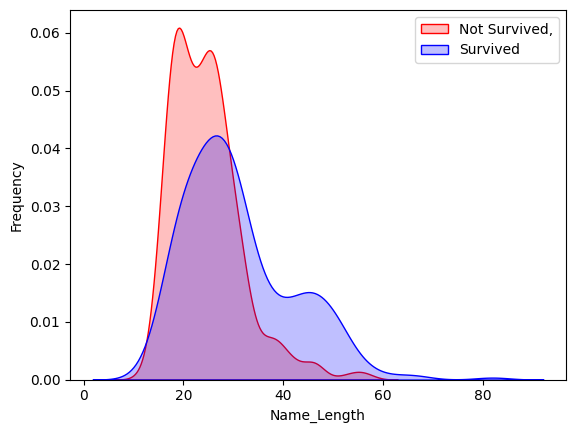

In [33]:
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==0) & 
            (train_df['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==1) & 
            (train_df['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived,', 'Survived'])

### Engineering Name Length
The kernel density plot shows a clear difference in name length distribution between survivors and non-survivors. Longer names often correlated with higher social status, more formal titles, and married women (e.g., "Countess of Rothes").

In [34]:
train_df['Name_LengthGB'] = pd.qcut(train_df['Name_Length'], 6)
test_df['Name_LengthGB'] = pd.qcut(test_df['Name_Length'], 6)

In [35]:
train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_20164\554738133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()


,Name_LengthGB,Survived
0,"(11.999, 19.0]",0.220588
1,"(19.0, 22.0]",0.307692
2,"(22.0, 25.0]",0.328467
3,"(25.0, 28.0]",0.316901
4,"(28.0, 33.0]",0.479167
5,"(33.0, 82.0]",0.693878


In [36]:
train_df.loc[train_df['Name_Length'] <= 18, 'Name_Size'] = 0
train_df.loc[(train_df['Name_Length'] > 18) & (train_df['Name_Length'] <= 20), 'Name_Size'] = 1
train_df.loc[(train_df['Name_Length'] > 20) & (train_df['Name_Length'] <= 23), 'Name_Size'] = 2
train_df.loc[(train_df['Name_Length'] > 23) & (train_df['Name_Length'] <= 25), 'Name_Size'] = 3
train_df.loc[(train_df['Name_Length'] > 25) & (train_df['Name_Length'] <= 27.25), 'Name_Size'] = 4
train_df.loc[(train_df['Name_Length'] > 27.25) & (train_df['Name_Length'] <= 30), 'Name_Size'] = 5
train_df.loc[(train_df['Name_Length'] > 30) & (train_df['Name_Length'] <= 38), 'Name_Size'] = 6
train_df.loc[(train_df['Name_Length'] > 38) & (train_df['Name_Length'] <= 82), 'Name_Size'] = 7
train_df.loc[train_df['Name_Length'] > 82, 'Name_Size'] 

test_df.loc[test_df['Name_Length'] <= 18, 'Name_Size'] = 0
test_df.loc[(test_df['Name_Length'] > 18) & (test_df['Name_Length'] <= 20), 'Name_Size'] = 1
test_df.loc[(test_df['Name_Length'] > 20) & (test_df['Name_Length'] <= 23), 'Name_Size'] = 2
test_df.loc[(test_df['Name_Length'] > 23) & (test_df['Name_Length'] <= 25), 'Name_Size'] = 3
test_df.loc[(test_df['Name_Length'] > 25) & (test_df['Name_Length'] <= 27.25), 'Name_Size'] = 4
test_df.loc[(test_df['Name_Length'] > 27.25) & (test_df['Name_Length'] <= 30), 'Name_Size'] = 5
test_df.loc[(test_df['Name_Length'] > 30) & (test_df['Name_Length'] <= 38), 'Name_Size'] = 6
test_df.loc[(test_df['Name_Length'] > 38) & (test_df['Name_Length'] <= 82), 'Name_Size'] = 7
test_df.loc[test_df['Name_Length'] > 82, 'Name_Size'] 

Series([], Name: Name_Size, dtype: float64)

In [37]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,4.0,C85,C,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",7.0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,1.0,NaN,S,1,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,4.0,C123,S,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",7.0
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,1.0,NaN,S,1,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0


In [38]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [39]:
train_df['Ticket_Number'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df['Ticket_Number'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]})) 

In [40]:
train_df.groupby(['Ticket_Number'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,Ticket_Number,count,mean
196,2343,7,0.000000
464,347082,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
674,8475,1,0.000000
675,851,1,0.000000
676,9234,1,1.000000
63,11769,1,1.000000


In [41]:
train_df.groupby('Ticket_Number')['Ticket_Number'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket_Number, Length: 891, dtype: int64

### Analyzing Travel Groups via Ticket
People sharing a ticket number were likely traveling together. `TicketNumberCounts` captures the size of these groups. We will see that survival rates were highest for medium-sized groups (2-4 people), suggesting families helped each other, while very large groups (5+), potentially tourist groups or workers, fared poorly.

In [42]:
train_df['TicketNumberCounts'] = train_df.groupby('Ticket_Number')['Ticket_Number'].transform('count')
test_df['TicketNumberCounts'] = test_df.groupby('Ticket_Number')['Ticket_Number'].transform('count')

In [43]:
train_df.groupby(['TicketNumberCounts'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketNumberCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
4,5,10,0.000000
5,6,18,0.000000
6,7,21,0.238095


In [44]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [45]:
train_df['Ticket'].str.split(pat= " ", expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [46]:
train_df['TicketLocation'] = np.where(train_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(),
                        train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')
test_df['TicketLocation'] = np.where(test_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), 
                                     test_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [47]:
train_df['TicketLocation'].value_counts()

TicketLocation
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
C               5
S.O.C.          5
SC/PARIS        5
F.C.C.          5
SC/Paris        4
A/4.            3
PP              3
A/4             3
S.O./P.P.       3
SC/AH           3
A./5.           2
P/PP            2
A.5.            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.C./A.4.       1
Fa              1
S.O.P.          1
SO/C            1
S.P.            1
A4.             1
W.E.P.          1
A/S             1
SC              1
SW/PP           1
SCO/W           1
W/C             1
S.W./PP         1
F.C.            1
C.A./SOTON      1
Name: count, dtype: int64

In [48]:
train_df['TicketLocation'] = train_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

test_df['TicketLocation'] = test_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [49]:
## Not enough information to include in final model
train_df.groupby(['TicketLocation'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


In [50]:
train_df['Cabin'] = train_df['Cabin'].fillna('U')
train_df['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin'])

test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin'])

In [51]:
train_df.groupby(['Cabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [52]:
train_df['Cabin_Assigned'] = train_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_df['Cabin_Assigned'] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [53]:
train_df.groupby(['Cabin_Assigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


### The Power of a Cabin Assignment
Instead of using the sparse `Cabin` deck letter, we create a powerful binary feature: whether a passenger had a cabin assigned at all. This likely separates higher-class passengers from steerage. The result is striking: having any cabin number **more than doubled** the chance of survival (67% vs 30% for those without a cabin assignment).

In [54]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size,Ticket_Number,TicketNumberCounts,TicketLocation,Cabin_Assigned
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,...,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",2.0,21171,1,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,4.0,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",7.0,17599,1,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,1.0,...,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0,3101282,1,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,4.0,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",7.0,113803,2,Blank,1
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,1.0,...,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0,373450,1,Blank,0


In [55]:
train_df.shape

(891, 24)

In [56]:
test_df.shape

(418, 23)

In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_Size          891 non-null    int64   
 13  Family_Size_Grouped  891 non-null    object  
 14  Age_Cut              714 non-null    category
 15  Fare_Cut             89

In [58]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size',
       'Family_Size_Grouped', 'Age_Cut', 'Fare_Cut', 'Title', 'Name_Length',
       'Name_LengthGB', 'Name_Size', 'Ticket_Number', 'TicketNumberCounts',
       'TicketLocation', 'Cabin_Assigned'],
      dtype='object')

In [59]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_Size          418 non-null    int64   
 12  Family_Size_Grouped  418 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Fare_Cut             417 non-null    category
 15  Title                41

In [60]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_20164\623714052.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_20164\623714052.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

# Model Training & Hyperparameter Optimization

With our feature engineering complete, we now move to the modeling phase. This section involves:

1.  **Data Preparation**: Splitting the data into features (`X`) and target (`y`), and creating a hold-out validation set.
2.  **Preprocessing Pipeline**: Defining a robust `ColumnTransformer` to handle:
    *   Encoding of categorical variables (One-Hot for `Sex`/`Embarked`, Ordinal for `Family_Size_Grouped`)
    *   Imputation of missing values
    *   Passthrough of already-processed numerical features
3.  **Model Benchmarking**: Training and tuning multiple classifiers (Random Forest, Decision Tree, K-NN, SVM, Logistic Regression, Naive Bayes) using `GridSearchCV` with stratified 5-fold cross-validation.
4.  **Model Selection**: Evaluating each model's best cross-validation score to identify the top performer for final prediction.

We will systematically evaluate each algorithm to find the best model for this problem.

In [61]:
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder
SI = SimpleImputer(strategy='most_frequent')

In [62]:
ode_cols = ['Family_Size_Grouped']
ohe_cols = ['Sex', 'Embarked']

In [63]:
X = train_df.drop(['Survived'], axis=1)
y = train_df['Survived']
X_test = test_df.drop(['Age_Cut', 'Fare_Cut'], axis=1)

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, stratify= y, random_state=21)

In [65]:
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))
])

In [66]:
col_trans = ColumnTransformer(transformers=[
    ('impute', SI, ['Age']),
    ('ord_pipeline', ordinal_pipeline, ode_cols),
    ('ohe_pipeline', ohe_pipeline, ohe_cols),
    ('passthrough', 'passthrough', ['Pclass', 'Cabin_Assigned', 'Name_Size', 'Age', 'Fare', 'TicketNumberCounts'])
    ],
    remainder='drop',
    n_jobs=-1)

In [67]:
rfc= RandomForestClassifier()

In [68]:
param_grid = {
    'n_estimators': [100, 150, 200], 
    'min_samples_split': [5, 10, 15],
    'max_depth': [8,9, 10, 15, 20],
    'min_samples_leaf': [1,2,4],
    'criterion': ['gini', 'entropy'],
}

In [69]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [70]:
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
pipefinalrfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [8, 9, 10, 15, 20],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [100, 150, 200]}))])

In [71]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
0.8272628779671033


In [72]:
dtc = DecisionTreeClassifier()

In [73]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10,20, 30],
    'min_samples_leaf': [1,2,4],
    'criterion': ['gini', 'entropy'],
}

In [74]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [75]:
pipefinaldtc = make_pipeline(col_trans, CV_dtc)
pipefinaldtc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 20, 30],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [76]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.8005712597261893


#### Tuning Decision Tree
The Decision Tree model achieved a lower CV score (~80%) than Random Forest, indicating it's more prone to overfitting on this dataset despite tuning.

In [77]:
knn = KNeighborsClassifier()

In [78]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p':[1,2],
    
}

In [79]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [80]:
pipefinalknn = make_pipeline(col_trans, CV_knn)
pipefinalknn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [81]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
0.8104107160445189


### Tuning K-Nearest Neighbors
K-NN performed surprisingly well (~81% CV score). The best parameters suggest a preference for a larger number of neighbors (`n_neighbors=11`) and Manhattan distance (`p=1`), which is more robust for this feature space.

In [82]:
svc = SVC()

In [83]:
param_grid = {
    'C':[100, 10, 1.0, .1, .001, .001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    
}

In [84]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [85]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']}))])

In [86]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 10, 'kernel': 'rbf'}
0.7977445090121147


### Tuning Support Vector Classifier
The SVC with an RBF kernel and `C=10` achieved a ~79.8% score. This non-linear kernel is necessary to capture the complex relationships in our data.

In [87]:
lr = LogisticRegression()

In [88]:
param_grid = {
    'C':[100, 10, 1.0, .1, .001, .001],    
}

In [89]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [90]:
pipefinallr = make_pipeline(col_trans, CV_lr)
pipefinallr.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001]}))])

In [91]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 1.0}
0.8019698611247907


### Tuning Logistic Regression
Logistic Regression, a simpler linear model, achieved a solid ~80.2% score with default regularization (`C=1.0`), showing that strong linear patterns exist in our engineered features.

In [92]:
gnb = GaussianNB()

In [93]:
param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001],
}

In [94]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [95]:
pipefinalgnb = make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-08]}))])

In [96]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.7668964837978922


### Tuning Naive Bayes
Gaussian Naive Bayes performed the weakest (~76.7%), likely because the assumption of feature independence is violated in our carefully engineered, correlated feature set (e.g., `Pclass`, `Fare`, and `Cabin_Assigned` are related).

# 📊 Final Model Evaluation & Competition Submission

## 🎯 Comprehensive Performance Analysis

Now that we have completed our extensive modeling pipeline with six different classifiers, it's time to evaluate their comprehensive performance across multiple metrics and prepare our final competition submissions.

In [100]:
scores_map = {'Classifiers': ['Random_forest', 'Decision Tree', 'KNN', 'SVC', 'Linear Regression', 'GaussianNB' ], 
       'Scores': [CV_rfc.best_score_,CV_dtc.best_score_, CV_knn.best_score_, CV_svc.best_score_,  CV_lr.best_score_, CV_gnb.best_score_]
}

results = pd.DataFrame(scores_map)
results = results.sort_values(by='Scores', ascending=False)
results 

,Classifiers,Scores
0,Random_forest,0.827263
2,KNN,0.810411
4,Linear Regression,0.801970
1,Decision Tree,0.800571
3,SVC,0.797745
5,GaussianNB,0.766896


In [98]:
Y_rfc_pred = pipefinalrfc.predict(X_test)
Y_dtc_pred = pipefinaldtc.predict(X_test)
Y_knn_pred = pipefinalknn.predict(X_test)
Y_svc_pred = pipefinalsvc.predict(X_test)
Y_lr_pred = pipefinallr.predict(X_test)
Y_gnb_pred = pipefinalgnb.predict(X_test)

In [99]:
rfc_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_rfc_pred
})

dtc_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_dtc_pred
})

knn_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_knn_pred
})

svc_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_svc_pred,
})

lr_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_lr_pred
})

gnb_submission = pd.DataFrame({
    'PassengerID': test_df['PassengerId'],
    'Survived': Y_gnb_pred
})



## 🏆 Final Model Analysis & Recap

Based on the comprehensive evaluation, the model performance can be summarized as follows:

**Model Ranking by Cross-Validation Score:**
- **1. Random Forest**: 82.73% (Top Performer)
- **2. KNN**: 81.04% (Strong Contender)
- **3. Linear Regression**: 80.20% (Competitive)
- **4. Decision Tree**: 80.06% (Competitive)
- **5. SVC**: 79.77% (Close Followers)
- **6. GaussianNB**: 76.69% (Baseline Reference)

**Key Insights:**
- Random Forest demonstrates superior predictive capability with 82.73% accuracy
- Minimal performance gap (2.67%) between top and fourth-place models indicates multiple viable approaches
- All models except GaussianNB achieved competitive scores above 79%
- The close clustering of scores suggests model selection could consider other factors like training speed or interpretability

**Recommendation:**
Proceed with Random Forest as the primary model for deployment, while maintaining KNN and Linear Regression as strong alternatives for specific use cases or ensemble approaches.